In [1]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()


Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=672540515 seed_offset=0 real_seed=672540515
core.init.random: RandomGenerator:i

In [2]:
import math
import random
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.id import *
from recces.data import *
from recces.util import *
from rosetta.protocols.rna import *

/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  # This is added back by InteractiveShellApp.init_path()


In [3]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [4]:
def initialize_pose(seq1, seq2):
    
    n_residues = len(seq1) + len(seq2)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq1, seq2)
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
    
        if seq2 and ii == (n_residues/2) - 1: continue
            
        dof_dict.update({6*ii:TorsionID(ii+2, BB, 1), 6*ii+1:TorsionID(ii+2, BB, 2), 6*ii+2:TorsionID(ii+2, BB, 3),
                 6*ii+3:TorsionID(ii+1, BB, 5), 6*ii+4:TorsionID(ii+1, BB, 6)})

        movemap.set(TorsionID(ii+2, BB, 1), True)
        movemap.set(TorsionID(ii+2, BB, 2), True)
        movemap.set(TorsionID(ii+2, BB, 3), True)
        movemap.set(TorsionID(ii+1, BB, 5), True)
        movemap.set(TorsionID(ii+1, BB, 6), True)
        
    for ii in range(n_residues-1):
        
        dof_dict.update({6*ii+5:TorsionID(ii+1, CHI, 1)})
        
    dof_dict.update({6*(n_residues-1):TorsionID(n_residues, CHI, 1)})
    
    movemap.set_chi(True)
        
        
        
    return pose, movemap, dof_dict

In [5]:
def find_minimum(pose, sf, movemap):
    
    
    minimum = Pose()
    minimum.assign(pose)
    
    n_residues = pose.total_residue()
    
    movemap = MoveMap()
    for ii in range(n_residues-1):
        
        minimum.set_alpha(  ii+2, random.uniform(0, 360))
        minimum.set_beta(   ii+2, random.uniform(0, 360))
        minimum.set_gamma(  ii+2, random.uniform(0, 360))
        minimum.set_epsilon(ii+1, random.uniform(0, 360))
        minimum.set_zeta(   ii+1, random.uniform(0, 360))
             
    for ii in range(n_residues):
        
        pose.set_chi(ii+1, random.uniform(0, 360))

    
    minmover = rosetta.protocols.minimization_packing.MinMover(movemap, sf, 'linmin_iterated', 1e-6, True)
    minmover.max_iter(100000)
    minmover.apply(minimum)
    
    return minimum   

In [6]:
def helix_state(pose, dof_dict):
    
    n_residues = pose.total_residue()
    
    # Definition of helix state backbone torsions
    for ii in range(n_residues - 1):
        
        if ii == n_residues/2 - 1: continue
        
        pose.set_torsion(dof_dict[6*ii], -64.11)
        pose.set_torsion(dof_dict[6*ii+1], 176.33)
        pose.set_torsion(dof_dict[6*ii+2], 53.08)
        pose.set_torsion(dof_dict[6*ii+3], -150.17)
        pose.set_torsion(dof_dict[6*ii+4], -71.45)   
       
    # Definition of helix state chi torsions
    for ii in range(n_residues-1): pose.set_torsion(dof_dict[6*ii+5], 79.43)
    
    return pose

In [7]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = 0.0
    
    max_inc = int(60/h)

    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + (60.0)*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):

            if key > len(dofs)/2 -2: key += 5
            temp.set_torsion(dof_dict[key], val)
        
        E = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)

    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    E = E_0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + 60.0*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):
            
            if key > len(dofs)/2 - 2: key += 5 
            temp.set_torsion(dof_dict[key], val)
        E  = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)
        
    result *= h*np.pi/180.0
    return result

In [8]:
rna_hires = protocols.rna.denovo.get_rna_hires_scorefxn()

core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
basic.io.database: Database file opened: scoring/score_functions/carbon_hbond/ch_o_bond_potential.dat


In [9]:
rna_hires = protocols.rna.denovo.get_rna_hires_scorefxn()
#rna_hires = core.scoring.ScoreFunctionFactory.create_score_function('rna/denovo/rna_hires_recces')
#rna_hires.set_weight(core.scoring.geom_sol, 0)
#rna_hires.set_weight(core.scoring.ch_bond, 0)
#rna_hires.set_weight(core.scoring.rna_sugar_close, 0)
rna_hires.set_weight(core.scoring.ch_bond, 0.)
rna_hires.set_weight(core.scoring.rna_sugar_close, 0.)
rna_hires.set_weight(core.scoring.hbond_lr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sc, 0.)
rna_hires.set_weight(core.scoring.geom_sol, 0.)
rna_hires.set_weight(core.scoring.atom_pair_constraint, 0.)
rna_hires.set_weight(core.scoring.fa_atr,0.73)
rna_hires.set_weight(core.scoring.fa_rep, 0.10)
rna_hires.set_weight(core.scoring.fa_intra_rep, 0.0071) 
rna_hires.set_weight(core.scoring.lk_nonpolar, 0.25) 
rna_hires.set_weight(core.scoring.fa_elec_rna_phos_phos, 4.54) 
rna_hires.set_weight(core.scoring.rna_torsion, 4.26) 
rna_hires.set_weight(core.scoring.stack_elec, 1.54) 
rna_hires.set_weight(core.scoring.hbond_sc, 2.46)
np.heaviside
print rna_hires

ScoreFunction::show():
weights: (fa_atr 0.73) (fa_rep 0.1) (fa_intra_rep 0.0071) (lk_nonpolar 0.25) (fa_elec_rna_phos_phos 4.54) (rna_torsion 4.26) (stack_elec 1.54) (hbond_sc 2.46)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files: 
EnergyMethodOptions::show: netcharge_setup_files: 
EnergyMethodOptions::show: aspartimide_penalty_value: 25
EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
EnergyMethodOptions::show: exclude_monomer_fa_elec: false
EnergyMethodOptions::show: 

In [10]:
CURR_WT = [0.73, 0.1, 0.0071, 0, 4.26, 2.46, 0.25, 0, 1.54, 4.54]

In [11]:
seq1 = 'ggg'
seq2 = 'ccc'

# Specify local path to where RECCES results are stored
try: 
    hist = SingleHistSimulation('./../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/')
    print hist.value
    
except ValueError: pass
except IndexError: pass

n_residues = len(seq1) + len(seq2)

pose, movemap, dof_dict = initialize_pose(seq1, seq2)
pyrosetta.rosetta.protocols.rna.denovo.setup_coarse_chainbreak_constraints(pose, 2)
#pose = pose_from_pdb('aaa_uuu_chainbreak.pdb')
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('/stepwise/rna/turner')
scorefxn = rna_hires
#scorefxn.set_weight(core.scoring.lk_nonpolar, 0)
#scorefxn.set_weight(core.scoring.stack_elec, 0)


Inferring sequence from directory name:  ggg_ccc
applying phase space volume for two strand with helix length  3  and dangle length  0
-33.26841292402865
core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 603 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 1.09375 seconds.
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.


In [12]:
minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'lbfgs_armijo', 1.0e-7, True)
minmover.max_iter(1000000)
minmover.min_options().use_nblist(True)
minmover.min_options().nblist_auto_update(True)

#pyrosetta.rosetta.protocols.rna.denovo.setup_coarse_chainbreak_constraints(pose, 2)

In [13]:

import itertools

minimum = Pose()

pose.assign(helix_state(pose, dof_dict))
minmover.apply(pose)
minimum.assign(pose)
print scorefxn.show(pose)
h = 0.1
h_rad = h*np.pi/180
E_0 = scorefxn(pose)

dofs = []

for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
dofs = np.array(dofs)

hessian = np.zeros((len(dofs), len(dofs)))

n_pts = int(1/h + 1)
ind = int(n_pts/2)

tor_ranges = np.zeros((n_pts, len(dofs)))
energy = np.zeros((n_pts, n_pts))

for ii, dof in enumerate(dofs):
            
    tor_ranges[:, ii] = dof + np.arange(-0.5, 0.5+h, h)
    
for pair in list(itertools.combinations(dof_dict.keys(), 2)):
    
    foo = pair[0]
    bar = pair[1]
    if foo > len(dofs)/2 - 2: foo -= 5
    if bar > len(dofs)/2 - 2: bar -= 5
    
    x = tor_ranges[:, foo]
    y = tor_ranges[:, bar]

    for ii, xx in enumerate(x):
            
        pose.set_torsion(dof_dict[pair[0]], xx)
        
        for jj, yy in enumerate(y):
            
            pose.set_torsion(dof_dict[pair[1]], yy)
            
            energy[ii, jj] = scorefxn(pose)

            pose.set_torsion(dof_dict[pair[1]], dofs[bar])
            
        pose.set_torsion(dof_dict[pair[0]], dofs[foo])
        
    hess = numpy_hessian(energy, h_rad)
    
    d2E_dx2 =  hess[0,0,:,:]
    d2E_dy2 =  hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[foo, foo] == 0:
        
        hessian[foo, foo] = d2E_dx2[ind, ind]
        
    if hessian[bar, bar] == 0:
        
        hessian[bar, bar] = d2E_dy2[ind, ind]
        
    hessian[foo, bar] = d2E_dxdy[ind, ind]
    hessian[bar, foo] = d2E_dxdy[ind, ind]
    
pose.assign(minimum)
try: scorefxn.show(ST_min)
except NameError: pass


core.scoring: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       0.730     -57.885     -42.256
 fa_rep                       0.100      36.163       3.616
 fa_intra_rep                 0.007      35.084       0.249
 lk_nonpolar                  0.250      -6.733      -1.683
 fa_elec_rna_phos_phos        4.540      -0.283      -1.283
 rna_torsion                  4.260       0.399       1.700
 stack_elec                   1.540      -0.903      -1.391
 hbond_sc                     2.460     -13.193     -32.454
---------------------------------------------------
 Total weighted score:                      -73.501
None


In [14]:
import scipy
import scipy.linalg

w,v = scipy.linalg.eigh(hessian)
print w

[1.09150836e+00 3.14292778e+00 4.26043581e+00 4.67139544e+00
 1.02103346e+01 1.07400869e+01 1.13718052e+01 1.42413188e+01
 1.65100396e+01 2.32347041e+01 2.44580208e+01 3.71901903e+01
 5.21816920e+01 7.31782368e+01 9.75400290e+01 1.32731709e+02
 2.11872339e+02 3.36836474e+02 4.21212447e+02 1.14403874e+03
 1.23460526e+03 1.28196495e+03 2.57105983e+03 5.74925766e+03
 1.06835865e+04 1.78867075e+04]


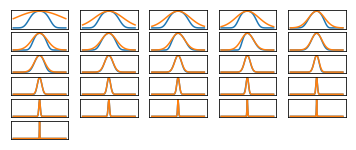

In [15]:
'''this code will assay the normal modes, plotting the corresponding boltzmann weights for both the harmonic approximation
and scanned modes'''

import scipy.integrate

pose.assign(minimum)
E_min = scorefxn(minimum)
kT = 1.0
fig = plt.figure()
for kk, K in enumerate(w):
 
    mode = v[:,kk]
    h = np.arange(-60,61,1)
    h_plot = h*np.pi/180

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            if jj > len(dofs)/2 - 2: jj += 5
            pose.set_torsion(dof_dict[jj], dof)

        bar.append((scorefxn(pose)-E_0)/kT)

    np.array(bar) 
    pose.assign(minimum)
    plt.subplot(10,5, kk+1)
    plt.plot(h, np.exp(-np.array(bar)))
    plt.plot(h, np.exp(-0.5*K*h_plot**2/kT))
    plt.xticks([])
    plt.yticks([])
    #plt.xlabel('Displacement along normal coordinate (degrees)')
    #plt.ylabel('exp(-(E-E0)/kT)')


In [16]:
'''this code will calculate the configuration integral using both harmonic approximation and mode scanning'''

from scipy.special import *
pose.assign(minimum)
V = 1
kT = 1.0
Z_harm = 1.00
Z_scan = 1.00
Z = 1.00
for ii, K in enumerate(w):

    # Mode scanning
    Z_j = mode_scan(pose, dofs, dof_dict, scorefxn, v[:,ii], kT, h = 1)
    
    sig = 6*np.sqrt(kT/K)
    V*=sig
    # Harmonic approximation
    Z_i = np.sqrt(2.0*np.pi*kT/K)*erf(np.sqrt(2.0*K/kT)*sig/4.0)
    
    Z_harm *= Z_i
    Z_scan *= Z_j
    
    if abs(np.log(Z_i/Z_j))<0.5: Z *= Z_i
    else: Z*=Z_j
    pose.assign(minimum)
    
    print Z_i, Z_j

2.3927774539786113 0.8138745517434851
1.4100958718901304 0.8268933423452567
1.2111246096513284 0.808579924215642
1.1566248681370175 0.6921207266218282
0.7823405729138998 0.5696776231373992
0.7628022134392629 0.5576601636294863
0.7413121794611197 0.5729450770986172
0.6624311363609253 0.6164825904112926
0.615236063481506 0.5889873961797649
0.5186176212931272 0.4626305264617998
0.5054814084471805 0.4336171016340518
0.4099223913310621 0.3884689321698648
0.3460642711791337 0.32710972463964116
0.29223004935880725 0.2872911000900461
0.2531187993480365 0.23028934736085938
0.2169843934729321 0.21626651705222136
0.17174286832639207 0.1776988924626213
0.13620915086867205 0.1322287006721015
0.12180503583637577 0.11441480866350548
0.07390868507179367 0.0798051101432602
0.07114621182589113 0.07382891040363705
0.06981966592466185 0.06755394358025135
0.04930145660911971 0.04740916641587391
0.03296931740929584 0.03133238675947042
0.02418562457092883 0.02097946159999035
0.018691779076315276 0.0196066903

In [20]:
print scorefxn(minimum) - np.log(Z_harm), scorefxn(minimum) - np.log(Z_scan), scorefxn(minimum) - 0.5*len(v)*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(hessian))

# Equipartition theorem average internal energy
E_avg = scorefxn(minimum) + 0.5*len(v)
print E_avg
F = scorefxn(minimum) - np.log(Z_scan)
print F - np.log(torsion_volume(seq1, seq2))
# Harmonic approximation free energy
fuck = E_min - 0.5*len(w)*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(hessian))
print fuck + len(w)*np.log(2*np.pi/3)

# Entropy from definition of free energy
#print E_avg - F

sim = SingleSimulation('./../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/', CURR_WT)

#print sim.value, sim.avg_energy, sim.entropy
print sim.value + np.log(torsion_volume(seq1, seq2))

#print sim.entropy, -np.log(np.sum(matt_guess(E)))
print (fuck - sim.value)/np.log(len(w))

-38.023246529006016 -33.83557136212771 -38.09353615322836
-60.5010970023
applying phase space volume for two strand with helix length  3  and dangle length  0
-53.05645558339984
-18.87265193195623
Inferring sequence from directory name:  ggg_ccc
Created:  hist_list.txt
applying phase space volume for two strand with helix length  3  and dangle length  0
applying phase space volume for two strand with helix length  3  and dangle length  0
-14.047975251331586
-1.480826803110777


In [ ]:
print 0.6163*(scorefxn(minimum) - np.log(Z_scan))

In [720]:
def partition_function(beta):
    
    Z = 1.0
    
    for K in w:
        
        sig = min(2*np.pi/3.0, 6*np.sqrt(1/kT))
        Z *= np.sqrt(2.0*np.pi/K/beta)*erf(np.sqrt(2.0*K*beta)*sig/4.0)
        
    return Z

In [721]:
'this code defines an implementation of the Stehfest method for numerically calculating the inverse laplace transform'
import scipy.misc

fact = scipy.misc.factorial

def csteh(n, i):
    acc = 0.0
    for k in xrange(int(np.floor((i+1)/2.0)), int(min(i, n/2.0))+1):
        num = k**(n/2.0) * fact(2 * k)
        den = fact(i - k) * fact(k -1) * fact(k) * fact(2*k - i) * fact(n/2.0 - k)
        acc += (num /den)
    expo = i+n/2.0
    term = np.power(-1+0.0j,expo)
    res = term * acc
    return res.real

def nlinvsteh(t, F=partition_function, n = 18):
    acc = 0.0
    lton2 = np.log(2) / t
    for i in xrange(1, n+1):
        a = csteh(n, i)
        b = F(i * lton2)
        acc += (a * b)
        
    if lton2 * acc > 0.: return lton2 * acc
    else: return 0.

In [722]:
t = np.linspace(0,800,8001)
A = []
for tt in t: A.append(nlinvsteh(tt))
t = np.array(t)
A = np.array(A)
A[A<0.]=0.0


/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  if __name__ == '__main__':
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


Inferring sequence from directory name:  gg_cc
applying phase space volume for two strand with helix length  2  and dangle length  0
applying phase space volume for two strand with helix length  2  and dangle length  0
1.000000000000001


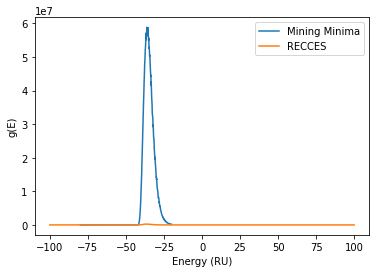

In [723]:
hist = SingleHistSimulation('./../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/')
#plt.plot(t[:1000]+rna_hires(minimum), A[:1000]*np.exp(-t[:1000]/1.0)*np.exp(-scorefxn(minimum)))
print np.sum(hist._dos)/torsion_volume(seq1, seq2)
plt.plot(hist._dos_scores[201:800], hist._dos[201:800]*np.exp(-hist._dos_scores[201:800]/1.0))
plt.plot(E[:2000], matt_guess(E[:2000])*np.exp(-(E[:2000])/1.0)/100)
plt.xlabel('Energy (RU)')
plt.ylabel('g(E)')
plt.legend(('Mining Minima', 'RECCES', 'Analytical'))

In [ ]:
bar = scipy.special.logsumexp(-(t+rna_hires(minimum)), b = A)
print bar
print scipy.special.logsumexp(-hist._dos_scores, b = hist._dos)

In [ ]:
plt.plot(t[:1000]+rna_hires(minimum),np.exp(-(t[:1000]+scorefxn(minimum))/1.0)*A[:1000]/np.exp(-scorefxn(minimum))*4e14)
plt.plot(hist._dos_scores[260:1200],hist._dos[260:1200]*np.exp(-(hist._dos_scores[260:1200]/1.0)))

In [ ]:

print t[100:] + scorefxn(minimum)

In [ ]:
from recces.util import *
from recces.data import *
curr_wt = [0.73, 0.1, 0.0071, 0, 4.26, 2.46, 0.25, 0, 1.54, 4.54]

In [540]:
E = np.linspace(-100,800,9001)

In [815]:
E_min = rna_hires(minimum)
print E_avg
gamma = scipy.special.gamma

-35.6115330181


In [825]:
matt_guess = lambda E: (2.0*np.pi)**(len(w)/2)*(E-E_min)**(len(w)/2 - 1)/gamma(len(w)/2)/np.sqrt(np.linalg.det(hessian))*np.heaviside(E-E_min, 0.5)#2*(2*np.pi)**((len(w)-1)/2)*(2*(E-E_min))**(len(w)/2-1)/scipy.misc.factorial2(len(w)-2)/np.sqrt(np.linalg.det(hessian))*np.heaviside(E-E_min,0.5)

applying phase space volume for two strand with helix length  3  and dangle length  0
0.9999999999999986
194.4894057560088


Text(0,0.5,'$g(E)e^{-E/kT}$')

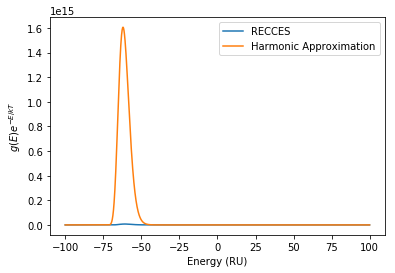

In [826]:
#plt.plot(t[:1000]+rna_hires(minimum),np.exp(-(t[:1000])/1.0)*A[:1000]*1e12)# numerical 
#plt.plot(t[:1000]+E_avg, harmonic_dos(t[:1000])*np.exp(-((t[:1000])/1.00))/torsion_volume(seq1,seq2)*5e17)# harmonic#
fig = plt.figure()
plt.plot(hist._dos_scores[:2000], hist._dos[:2000]*np.exp(-hist._dos_scores[:2000]/1.0)) # RECCES
print np.sum(hist._dos)/torsion_volume(seq1, seq2)

y = np.zeros_like(E)
y = matt_guess(E)
'''for i, xx in enumerate(E):
    
    if xx < E_avg: continue
    y[i] = matt_guess(xx)
'''  
print np.exp(np.log(np.sum(y*np.exp(-E))/np.sum(hist._dos*np.exp(-hist._dos_scores))))
plt.plot(E[:2000], y[:2000]*np.exp(-(E[:2000])/1.0))# Matt's guess for analytical
plt.legend(('RECCES','Harmonic Approximation'))
plt.xlabel('Energy (RU)')
plt.ylabel('$g(E)e^{-E/kT}$')


In [802]:
print hist._dos_scores
dos_scores = np.array(hist._dos_scores)
dos = np.array(hist._dos)
print -scipy.misc.logsumexp(-dos_scores,b=dos)
print hist.value
print -scipy.misc.logsumexp(-(E), b=y)

[-100.   -99.9  -99.8 ...  799.8  799.9  800. ]
-33.26841292402865
-33.26841292402865
-32.078355079503055


/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  after removing the cwd from sys.path.
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


In [ ]:
plt.plot(t[:1000]+E_avg, matt_guess(t[:1000])*np.exp(-(t[:1000])/1.0))

In [ ]:
bar = -scipy.special.logsumexp(-(E), b=y)
print bar
print sim.value

In [ ]:
plt.plot(t[:1000]+scorefxn(minimum), harmonic_dos(t[:1000]-E_avg)*np.exp(-(t[:1000]+scorefxn(minimum))))

In [ ]:
print bar - np.log(torsion_volume(seq1, seq2))
print hist.value - np.log(torsion_volume(seq1, seq2))

In [ ]:
print pose.annotated_sequence()

In [ ]:
pyrosetta.rosetta.protocols.rna.denovo.setup_coarse_chainbreak_constraints(pose, 2)

In [ ]:
print pose.annotated_sequence()
print minimum.fold_tree()

In [ ]:
def wang_landau(K):
    '''Computes the density of states using the Wang-Landau algorithm (see, e.g., )'''
    
    #E = lambda x: 0.5*np.dot(K, x**2)
    
    E = mm_energy(pose, )
    dr = 0.005
    f = np.exp(1)
    r = np.arange(0,50,dr)
    g = np.zeros_like(r)
    H = np.zeros_like(r)
    x_0 = 0.05*np.ones_like(K)
    print E(x_0)
    
    while f > np.exp(1e-8):
    
        ii = 0
        print f
        while ii < 100000:

            x = np.random.uniform(0, 0.08, (len(K)))
            x_ind = int(E(x)/dr)
            x_0_ind = int(E(x_0)/dr)
            if x_ind > H.shape[0]-1: continue

            if np.log(g[x_ind]) < np.log(g[x_0_ind]) or np.exp(np.log(g[x_ind])-np.log(g[x_0_ind])) < np.random.uniform():


                H[x_ind] += 1
                g[x_ind] += f
                x_0 = x

            else: 

                H[x_0_ind] += 1
                g[x_0_ind] += f
                
            ii += 1

        if H.any < 0.95*np.average(H): continue 

        f = f**0.5
        H = np.zeros_like(r)

    return g, r

In [ ]:
g, r = wang_landau(w)
g = g/max(g)

In [ ]:
plt.plot(r, np.exp(g)*np.exp(-r))
print -np.log(scipy.special.logsumexp(-(r+scorefxn(minimum)), b=g)) - np.log(torsion_volume(seq1, seq2))

In [ ]:
plt.plot(r, np.exp(g))

In [235]:
def mm_energy(pose, delta, dof_dict, sf):
    
    temp = Pose()
    temp.assign(pose)
            
    for key, val in enumerate(delta):

        if key > len(delta)/2 -2: key += 5
        temp.set_torsion(dof_dict[key], temp.torsion(dof_dict[key]) + val)
        
    return sf(temp)

In [236]:
norm = np.sum(hist._dos)

In [237]:
print np.log(norm*torsion_volume(seq1, seq2))

applying phase space volume for two strand with helix length  3  and dangle length  0
38.44176844254426


In [238]:
max(matt_guess(E[1000:2000])*np.exp(-E[1000:2000]))

/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `factorial2` is deprecated!
Importing `factorial2` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial2` instead.
  """Entry point for launching an IPython kernel.


0.002016351315624202

In [239]:
dr = 0.1
r = np.arange(-100,800+dr,dr)
g = np.zeros_like(r)
H = np.zeros_like(r)

f = np.exp(1)
sig = 1/np.sqrt(w)

delta_0 = np.zeros_like(w)
E_min = scorefxn(minimum)
E_0 = E_min

while np.log(f) > 1e-8:

    print f
    ii = 0
    H[:] = 0
    
    while ii < 10000:

        y = np.random.randint(10,len(w))
        delta = np.random.uniform(-180,180)*v[:,y]

        #delta = np.random.uniform(-np.pi/3, np.pi/3, len(w))
        #y = np.random.randint(0,len(w))
        #delta = v[:,y]*np.random.uniform(-np.pi/3,np.pi/3)
        
        #E = E_min + 0.5*np.dot(w,delta**2)
        E = mm_energy(minimum, delta, dof_dict, scorefxn)
        #E = mm_energy(minimum, delta, dof_dict, scorefxn)

    
        ind = int((E+100)/dr)
        ind_0 = int((E_0+100)/dr)

        if ind > len(r) -1: ind = -1
        if ind_0 > len(r) - 1: ind_0 = -1
        #H[ind] += 1
        #ii += 1
        if np.random.uniform() < np.exp(g[ind_0]-g[ind]):
            
            g[ind] += np.log(f)
            H[ind] += 1
            delta_0 = delta
            E_0 = E
        
            
        else:

            g[ind_0] += np.log(f)
            H[ind_0] += 1
            
        ii += 1
            
    #if H.any() < 1: continue   
    f = np.sqrt(f)




2.718281828459045
1.6487212707001282
1.2840254166877414
1.1331484530668263
1.0644944589178595
1.0317434074991028
1.0157477085866857
1.007843097206448
1.0039138893383477
1.0019550335910028
1.0009770394924165
1.0004884004786945
1.0002441704297478
1.0001220777633837
1.000061037018933
1.000030518043791
1.0000152589054783
1.000007629423635
1.0000038147045416
1.0000019073504518
1.0000009536747712
1.000000476837272
1.0000002384186075
1.0000001192092967
1.0000000596046466
1.0000000298023228
1.0000000149011612


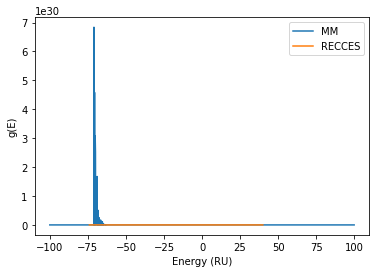

In [240]:
plt.plot(r[:2000], H[:2000]*np.exp(-r[:2000]))
#print -scipy.special.logsumexp(-r, b=H/2e17) - np.log(torsion_volume(seq1, seq2))
#plt.plot(t[:600]+E_min, 0.15*A[:600]*torsion_volume(seq1, seq2)*np.exp(-t[:600]/1.0)*(np.pi/6)**len(w)*2e14)
plt.plot(hist._dos_scores[260:1400], hist._dos[260:1400]*np.exp(-hist._dos_scores[260:1400])/1e7)
plt.xlabel('Energy (RU)')
plt.ylabel('g(E)')
plt.legend(('MM', 'RECCES'))

In [ ]:
print scorefxn(minimum) / 0.1

In [ ]:
np.set_printoptions(threshold='nan')

In [ ]:
print h

In [ ]:
print g

In [ ]:
print g

In [ ]:
plt.plot(t[:600]+rna_hires(minimum), 0.15*A[:600]*torsion_volume(seq1, seq2)*np.exp(-t[:600]/1.0)*(np.pi/6)**len(w)*2e14)
plt.plot(r[:-1], g[:-1]*np.exp(-r[:-1])/2e21)

In [ ]:
print H

In [ ]:
g1 = g

In [ ]:
g2 = g
fuck = np.convolve(g1, g2)
print fuck

In [ ]:
hist.value

In [ ]:
1/np.sqrt(scipy.linalg.det(hessian))

In [ ]:
sim = SingleSimulation('./../recces_rosetta/results/ggg_ccc/ST/', curr_wt)

In [ ]:
print sim.entropy

In [ ]:
print -scipy.special.logsumexp(-(hist._dos_scores + hist.value), b=hist._dos*hist._dos_scores)

In [ ]:
print hist.value

In [ ]:
print hist._avg_energy

In [ ]:

print sim.value - sim._avg_energy


In [ ]:
clear sim

In [ ]:
hist = SingleHistSimulation('./../recces_rosetta/results/gg_cc/ST')

In [ ]:
plt.plot(hist._dos_scores[:-1], hist._dos[:-1]*np.exp(-hist._dos_scores[:-1]))

In [ ]:
recces_options = protocols.recces.options.RECCES_Options()


In [ ]:
recces_options.set_seq1('gg')
recces_options.set_seq2('cc')

In [ ]:
pose = protocols.recces.recces_pose_setup(recces_options)

In [ ]:
print (1/3.)**len(w)

In [ ]:
print E[260]

In [ ]:
fuck = protocols.recces.pose_setup_turner('gg','cc')
pmm = PyMOLMover()
pmm.apply(fuck)

In [1]:
print pose.residue(1)

NameError: name 'pose' is not defined

In [23]:
print pose.secstruct()
pose = protocols.recces.pose_setup_turner('gg', '')
print pose.secstruct()

LLLLLL
LL
